# **WQU Capstone Project**

### **Dynamic MACD Trading with Multi-modal Agent**

#### **Student Group 6386**
##### Sunil Sharma ([sunilksh+mscfe@outlook.com](mailto:sunilksh+mscfe@outlook.com))

---

### Objective

The objective of the notebook explore integration of an AI agent(AutoGen) together with Multimodal LLM(GPT-4o) to optimize Moving Average Convergence Divergence (MACD) trading strategy for a stock of company. This involves:

- Plotting historical stock price data with MACD indicators.
- Visually inspect the generated plots to establish initial MACD parameters.
- Back test the MACD trading strategy with selected parameters.
- Iteratively optimize the MACD parameters using back testing results.
- Conclude about the best MACD strategy/parameters.

### Imports

In [113]:
# Agent-related imports
import autogen
from autogen import AssistantAgent, UserProxyAgent, register_function
from autogen.agentchat.contrib.multimodal_conversable_agent import MultimodalConversableAgent
from autogen.cache import Cache

# Data manipulation and handling
import pandas as pd

# Plotting and visualization
import matplotlib.pyplot as plt
import mplfinance as mpf
from IPython.display import Image, display

# Backtesting and trading analysis
import backtrader as bt

# Standard library imports
import json
import os
from textwrap import dedent
from typing import Optional, Dict, Annotated

### Configuration and Constants

In [114]:
# Define key variables for the company, date range, and file path
company = "AAKASH"
start_date = "2022-01-01"
end_date = "2024-01-01"
file_path = f'../../data/DailyData/{company}.csv'

# Global variable to store the backtesting results
backtesting_result = None

In [115]:
# Function to load configuration settings from a JSON file based on a filter model
def load_config(filter_model: str):
    return autogen.config_list_from_json(
        "./CONFIG.json",
        filter_dict={"model": [filter_model]},
    )

# Load specific configurations for the 'gpt-4o' model
config_list_4o = load_config("gpt-4o")
config_list = load_config("gpt-4o")

# Define language model configuration settings
llm_config_4o = {"config_list": config_list_4o,"max_tokens":300,"temperature": 0.0}
llm_config = {"config_list": config_list,"max_tokens":300,"temperature": 0.0}

### Data Processing Classes

In [116]:
# Define a class to process MACD data from CSV files
class MACDDataProcessor:
    def __init__(self, csv_file_path: str):
        self.data = pd.read_csv(csv_file_path, parse_dates=['date'])
        self.data.set_index('date', inplace=True)

    # Filter data within the given date range
    def filter_data(self, start_date: str, end_date: str):
        self.filtered_data = self.data.loc[start_date:end_date]

    # Calculate the Exponential Moving Average (EMA) for the specified period
    def calculate_ema(self, period: int):
        return self.filtered_data['close'].ewm(span=period, adjust=False).mean()

    # Calculate the MACD components
    def calculate_macd(self):
        ema_short = self.calculate_ema(12)
        ema_long = self.calculate_ema(26)
        macd = ema_short - ema_long
        signal = macd.ewm(span=9, adjust=False).mean()
        histogram = macd - signal
        return ema_short, ema_long, macd, signal, histogram

    # Get the filtered data as a dictionary
    def get_filtered_data(self):
        return self.filtered_data.to_dict()

    # Get the MACD components as dictionaries
    def get_macd_components(self):
        ema_short, ema_long, macd, signal, histogram = self.calculate_macd()
        return {
            'ema_short': ema_short.to_dict(),
            'ema_long': ema_long.to_dict(),
            'macd': macd.to_dict(),
            'signal': signal.to_dict(),
            'histogram': histogram.to_dict()
        }

    # Inspect the filtered data and MACD components for consistency
    def inspect_data(self):
        print("Filtered Data Info:")
        print(self.filtered_data.info())
        ema_short, ema_long, macd, signal, histogram = self.calculate_macd()
        print("EMA Short Length:", len(ema_short))
        print("EMA Long Length:", len(ema_long))
        print("MACD Length:", len(macd))
        print("Signal Length:", len(signal))
        print("Histogram Length:", len(histogram))
        print("Filtered Data Head:\n", self.filtered_data.head())
        print("EMA Short Head:\n", ema_short.head())
        print("EMA Long Head:\n", ema_long.head())
        print("MACD Head:\n", macd.head())
        print("Signal Head:\n", signal.head())
        print("Histogram Head:\n", histogram.head())

### Plotting Class

In [118]:
import numpy as np

# Define a class for plotting MACD charts
class MACDPlotter:
    def __init__(self, csv_file_path: str):
        self.processor = MACDDataProcessor(csv_file_path)
        
    def plot_macd(self, start_date: str, end_date: str, save_path: str, plot_type: str = "candle", plot_style: str = "default", show_nontrading: bool = False):
        self.processor.filter_data(start_date, end_date)
        ema_short, ema_long, macd, signal, histogram = self.processor.calculate_macd()

        # Detect crossover points
        crossover_points = ((macd.shift(1) > signal.shift(1)) & (macd <= signal)) | ((macd.shift(1) < signal.shift(1)) & (macd >= signal))

        # Check for inconsistencies in the lengths of the series
        lengths = [len(ema_short), len(ema_long), len(macd), len(signal), len(histogram)]
        print("Lengths of MACD components:", lengths)
        if len(set(lengths)) != 1:
            print(f"Length inconsistency detected: {lengths}")
            return f"Error: Length inconsistency detected in MACD components. Lengths: {lengths}"

        ema_short_plot = mpf.make_addplot(ema_short, color='red', width=2.0, secondary_y=False, label='EMA Short')
        ema_long_plot = mpf.make_addplot(ema_long, color='green', width=2.0, secondary_y=False, label='EMA Long')

        crossover_series = pd.Series(np.nan, index=macd.index)
        crossover_series[crossover_points] = macd[crossover_points].values

        crossover_plot = mpf.make_addplot(crossover_series, type='scatter', markersize=50, marker='o', color='purple', panel=2, label='Crossovers')

        histogram_positive = histogram.where(histogram >= 0)
        histogram_negative = histogram.where(histogram < 0)

        histogram_positive_plot = mpf.make_addplot(histogram_positive, panel=2, type='bar', color='green', secondary_y=False, width=0.8)
        histogram_negative_plot = mpf.make_addplot(histogram_negative, panel=2, type='bar', color='red', secondary_y=False, width=0.8)
        macd_plot = mpf.make_addplot(macd, panel=2, color='blue', width=2.0, secondary_y=False, label='MACD', ylabel='MACD')
        signal_plot = mpf.make_addplot(signal, panel=2, color='magenta', width=2.0, secondary_y=False, label='Signal')

        apds = [ema_short_plot, ema_long_plot, histogram_positive_plot, histogram_negative_plot, macd_plot, signal_plot, crossover_plot]

        plot_params = {
            "type": plot_type,
            "style": plot_style,
            "addplot": apds,
            "volume": True,
            "title": "MACD with EMA and Histogram",
            "show_nontrading": show_nontrading,
            "savefig": save_path,
            "tight_layout": True,
            "figscale": 1.5,
            "figsize": (10, 6),
            "datetime_format": '%b %Y',
            "panel_ratios": (5, 2, 6)
        }

        fig, axlist = mpf.plot(self.processor.filtered_data, **plot_params, returnfig=True)

        fig.subplots_adjust(top=0.9, right=0.75)
        fig.suptitle('MACD with EMA and Histogram', y=0.95, fontsize=12)

        legend_lines_main = [
            axlist[0].plot([], [], color='red', linewidth=2, label='EMA Short')[0],
            axlist[0].plot([], [], color='green', linewidth=2, label='EMA Long')[0]
        ]
        legend_lines_macd = [
            axlist[2].plot([], [], color='blue', linewidth=2, label='MACD')[0],
            axlist[2].plot([], [], color='magenta', linewidth=2, label='Signal')[0]
        ]
        legend_lines_crossover = [
            axlist[2].plot([], [], color='purple', marker='o', markersize=10, linestyle='None', label='Crossovers')[0]
        ]

        axlist[2].bar([], [], color='green', label='Histogram Positive')
        axlist[2].bar([], [], color='red', label='Histogram Negative')

        axlist[0].legend(handles=legend_lines_main, loc='upper left', bbox_to_anchor=(1.05, 1))
        axlist[2].legend(handles=legend_lines_macd, loc='upper left', bbox_to_anchor=(1.05, 0.5))
        axlist[2].legend(handles=legend_lines_crossover, loc='upper left', bbox_to_anchor=(1.05, 0))

        plt.close(fig)

        return f"MACD chart saved to {save_path}"

### Backtesting Strategy and Utility Class

In [119]:
# Define the MACD strategy class for backtesting
class MACDStrategy(bt.Strategy):
    params = (('short_ema', 12), ('long_ema', 26), ('signal_ema', 9),)

    def __init__(self):
        self.macd = bt.indicators.MACD(
            self.data.close,
            period_me1=self.params.short_ema,
            period_me2=self.params.long_ema,
            period_signal=self.params.signal_ema
        )
        self.crossover = bt.indicators.CrossOver(self.macd.macd, self.macd.signal)

    def next(self):
        if self.crossover > 0:
            self.buy()
        elif self.crossover < 0:
            self.sell()

# Utility class to run backtests using the MACD strategy
class BackTraderUtils:
    def back_test_macd(
        self,
        csv_file_path: Annotated[str, "Path to CSV file containing historical stock data"],
        start_date: Annotated[str, "Start date of the backtest in 'YYYY-MM-DD' format"],
        end_date: Annotated[str, "End date of the backtest in 'YYYY-MM-DD' format"],
        strategy_params: Annotated[str, "JSON string of strategy parameters, e.g., '{\"short_ema\": 12, \"long_ema\": 26, \"signal_ema\": 9}'"] = "",
        cash: Annotated[float, "Initial cash for backtesting"] = 10000.0,
        save_fig: Optional[Annotated[str, "File path to save the backtest result plot"]] = None,
    ) -> str:
        """
        Use the Backtrader library to backtest the MACD strategy on historical stock data from a CSV file.
        """
        cerebro = bt.Cerebro()
        strategy_class = MACDStrategy
        try:
            strategy_params_dict = json.loads(strategy_params) if strategy_params else {}
        except json.JSONDecodeError:
            return "Error: Invalid JSON format for strategy_params."

        cerebro.addstrategy(strategy_class, **strategy_params_dict)

        # Read data from CSV file
        try:
            df = pd.read_csv(csv_file_path, parse_dates=['date'])
        except FileNotFoundError:
            return f"Error: File not found at {csv_file_path}."
        except pd.errors.ParserError:
            return "Error: Failed to parse CSV file."

        df['datetime'] = pd.to_datetime(df['date'])
        df.set_index('datetime', inplace=True)
        df = df[['open', 'high', 'low', 'close', 'volume']]

        # Filter the data based on the start and end date
        df = df.loc[start_date:end_date]
        
        # Ensure there are enough data points for the MACD calculation
        if len(df) < max(strategy_params_dict.get('short_ema', 12), strategy_params_dict.get('long_ema', 26), strategy_params_dict.get('signal_ema', 9)):
            return "Error: Not enough data available for the specified date range to calculate MACD."

        if df.empty:
            return "Error: No data available for the specified date range."
        
        # Rename columns to match Backtrader expectations
        df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

        # Create a data feed
        data = bt.feeds.PandasData(dataname=df)
        cerebro.adddata(data)
        
        # Set our desired cash start
        cerebro.broker.setcash(cash)

        # Attach analyzers
        cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="sharpe_ratio")
        cerebro.addanalyzer(bt.analyzers.DrawDown, _name="draw_down")
        cerebro.addanalyzer(bt.analyzers.Returns, _name="returns")
        cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="trade_analyzer")

        stats_dict: Dict[str, any] = {"Starting Portfolio Value": cerebro.broker.getvalue()}

        results = cerebro.run()  
        first_strategy = results[0]

        # Access analysis results
        stats_dict["Final Portfolio Value"] = cerebro.broker.getvalue()
        stats_dict["Sharpe Ratio"] = (
            first_strategy.analyzers.sharpe_ratio.get_analysis()
        )
        stats_dict["Drawdown"] = first_strategy.analyzers.draw_down.get_analysis()
        stats_dict["Returns"] = first_strategy.analyzers.returns.get_analysis()
        stats_dict["Trade Analysis"] = (
            first_strategy.analyzers.trade_analyzer.get_analysis()
        )

        if save_fig:
            directory = os.path.dirname(save_fig)
            if directory:
                os.makedirs(directory, exist_ok=True)
            plt.figure(figsize=(16, 10))
            cerebro.plot()
            plt.savefig(save_fig)
            plt.close()
        
        backtesting_result = stats_dict

        return "Back Test Finished. Results: \n" + json.dumps(stats_dict, indent=2)

### Tool Functions 

In [120]:
# Define a tool function to plot the MACD chart
def plot_macd_tool(
    csv_file_path: Annotated[str, "Path to CSV file containing historical stock data"],
    start_date: Annotated[str, "Start date of the historical data in 'YYYY-MM-DD' format"],
    end_date: Annotated[str, "End date of the historical data in 'YYYY-MM-DD' format"],
    save_path: Annotated[str, "File path where the plot should be saved"],
    plot_type: Annotated[str, "Type of the plot (e.g., 'candle', 'line')"] = "candle",
    plot_style: Annotated[str, "Style of the plot (e.g., 'default', 'yahoo')"] = "default",
    show_nontrading: Annotated[bool, "Whether to show non-trading days on the chart"] = False
) -> str:
    plotter = MACDPlotter(csv_file_path)
    return plotter.plot_macd(start_date, end_date, save_path, plot_type, plot_style, show_nontrading)

In [121]:
# Define a tool function to display an image from a file path
def display_image_tool(file_path: Annotated[str, "Path to the image file to be displayed"]):
    """
    Displays an image from the given file path using IPython.display.
    """
    try:
        display(Image(filename=file_path))
        return f"Displayed image from {file_path}"
    except Exception as e:
        return f"Failed to display image from {file_path}: {e}"

In [122]:
# Define a tool function to backtest the MACD strategy
def backtest_macd_tool(
    csv_file_path: Annotated[str, "Path to CSV file containing historical stock data"],
    start_date: Annotated[str, "Start date of the backtest in 'YYYY-MM-DD' format"],
    end_date: Annotated[str, "End date of the backtest in 'YYYY-MM-DD' format"],
    strategy_params: Annotated[str, "JSON string of strategy parameters, e.g., '{\"short_ema\": 12, \"long_ema\": 26, \"signal_ema\": 9}'"] = "",
    cash: Annotated[float, "Initial cash for backtesting"] = 10000.0,
    save_fig: Optional[Annotated[str, "File path to save the backtest result plot"]] = None,
) -> str:
    """
    Backtests a MACD strategy on historical stock data from a CSV file.
    """
    utils = BackTraderUtils()
    return utils.back_test_macd(csv_file_path, start_date, end_date, strategy_params, cash, save_fig)

In [123]:
# Define a tool function to retrieve backtesting results
def get_backtesting_result():
    """
    Retrieves the backtesting results stored in the global variable.
    """
    global backtesting_result
    if backtesting_result is None:
        return {"error": "No backtesting results available."}
    return backtesting_result

### Agents Configuration

In [124]:
# Configure the Trade Strategy Optimizer agent
trade_strategy_optimizer = MultimodalConversableAgent(
    name="Trade_Strategy_Optimizer",
    system_message=dedent(
        """
        You are a trading strategy optimizer who inspects financial charts and optimizes trading strategies.
        You have been tasked with developing a Moving average convergence/divergence (MACD) trading strategy.
        You have the following main actions to take:
        1. Ask the Backtesting_Specialist to plot historical stock price data with designated MACD indicators.
        2. Inspect the stock price chart carefully and determine MACD (short_ema, long_ema, and signal_ema) parameters.
        3. Highlight the exact points/periods where the MACD line crosses the Signal line and interpret their significance critically.
        4. Provide a logical explanation for the suggested parameters based on observed trends.
        5. Ask the Backtesting_Specialist to backtest the MACD trading strategy with designated parameters to evaluate its performance.
        6. Inspect the backtest result obtained from Backtesting_Specialist and from variable {backtesting_result}, analyze key performance metrics (e.g., drawdown, returns, Sharpe ratio, trade analysis).
        7. Based on the analysis, optimize the MACD parameters iteratively until satisfactory performance is achieved or until the maximum number of iterations (max_turns) is reached.
        8. Define acceptable performance benchmarks (e.g., minimum profit factor, maximum drawdown). If the strategy meets these benchmarks at any iteration, summarize the results and terminate the optimization early.
        9. Summarize the results and provide the best parameters at the end of the optimization process.
        10. Reply TERMINATE when you think the strategy is good enough.
        """
    ),
    llm_config=llm_config_4o,
)

# Configure the Backtesting Specialist agent
backtesting_specialist = AssistantAgent(
    name="Backtesting_Specialist",
    system_message=dedent(
        f"""
        You are a backtesting specialist with a strong command of quantitative analysis tools.
        You have two main tasks to perform, choose one each time you are asked by the Trade_Strategy_Optimizer:
        1. Plot historical stock price data for {company} in the file at {file_path} with MACD indicators (short_ema, long_ema, and signal_ema) according to the Trade_Strategy_Optimizer's need.
        2. Backtest the MACD trading strategy with designated parameters (short_ema, long_ema, and signal_ema) and save the results as an image file.
        
        For both tasks, after the tool calling, you should do as follows:
            1. Display the created and saved image file using the `display_image_tool` tool.
            2. Call the `get_backtesting_result` tool to retrieve the backtesting results,and store it in stored in the global variable `backtesting_result`.
            3. Provide a summary of the backtesting results including key metrics such as total returns, drawdown, Sharpe ratio, and trade analysis.
            4. Assume the saved image file is "test.png" and summary of backtesting results is stored in the global variable. Share both the image and `backtesting_result` ask to Optimize the MACD parameters (short_ema, long_ema, and signal_ema) based on this image <img test.png>, and based on Backtest results in the `backtesting_result` variable. TERMINATE."
        """
    ),
    llm_config=llm_config,
)

backtesting_specialist_executor = UserProxyAgent(
    name="Backtesting_Specialist_Executor",
    human_input_mode="NEVER",
    is_termination_msg=lambda x: x.get("content", "") and x.get("content", "").find("TERMINATE") >= 0,
    code_execution_config={
        "last_n_messages": 1,
        "work_dir": "coding",
        "use_docker": False,
    },
)

### Register Functions

In [125]:
# Register the plot_macd_tool function
register_function(
    plot_macd_tool,
    caller=backtesting_specialist,  
    executor=backtesting_specialist_executor, 
    name="plot_macd_tool", 
    description="Plots the MACD chart with EMA, MACD histogram, and signals, and saves the plot to a file.",  
)

# Register the backbacktest_macd_tool_test_macd function
register_function(
    backtest_macd_tool,
    caller=backtesting_specialist,  
    executor=backtesting_specialist_executor,  
    name="backtest_macd_tool", 
    description="Backtests a MACD trading strategy on historical stock data from a CSV file.",  
)

from autogen import register_function

# Register the display_image_tool function
register_function(
    display_image_tool,
    caller=backtesting_specialist,  
    executor=backtesting_specialist_executor,  
    name="display_image_tool",  
    description="Displays an image from the given file path using IPython.display.",  
)

# Register the function to retrieve backtesting results
register_function(
    get_backtesting_result,
    caller=backtesting_specialist,
    executor=backtesting_specialist_executor,
    name="get_backtesting_result",
    description="Retrieves the backtesting results stored in the global variable."
)


The return type of the function 'display_image_tool' is not annotated. Although annotating it is optional, the function should return either a string, a subclass of 'pydantic.BaseModel'.
The return type of the function 'get_backtesting_result' is not annotated. Although annotating it is optional, the function should return either a string, a subclass of 'pydantic.BaseModel'.


### Reflection Message

In [126]:
def reflection_message_analyst(recipient, messages, sender, config):
    print("Reflecting Trade_Strategy_Optimizer's response ...")
    last_msg = recipient.chat_messages_for_summary(sender)[-1]["content"]
    return (
        "Message from Trade_Strategy_Optimizer is as follows:"
        + last_msg
        + "\n\nBased on this information, conduct a backtest on the specified stock and MACD strategy, and report your backtesting results back to the Trade_Strategy_Optimizer."
    )

### User Proxy and Task Initialization

User_Proxy (to Trade_Strategy_Optimizer):


Based on AAKASH's stock data from 2022-01-01 to 2024-01-01 in the file at ../../data/DailyData/AAKASH.csv, determine the possible optimal parameters for a MACD Strategy over this period.
First, ask the backtesting_specialist to plot a candlestick chart of the stock price data with MACD indicators to visually carefully inspect the price movements and make an initial assessment.
Then, ask the backtesting_specialist to backtest the MACD (short_ema,long_ema and signal_ema) strategy parameters using the backtesting tool, and report results back for further optimization.


--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Trade_Strategy_Optimizer (to User_Proxy):

Sure, let's start by asking the Backtesting_Specialist to plot the historical stock price data with the designated MACD indicators.

---

**To the Backtesting_Specialist:**

Please plot a candlestick chart of AAKASH's stock pric

<IPython.core.display.Javascript object>

[runtime logging] log_function_use: autogen logger is None


Backtesting_Specialist_Executor (to Backtesting_Specialist):

Backtesting_Specialist_Executor (to Backtesting_Specialist):

***** Response from calling tool (call_wUvi86S7tpMHlFNhFxeRIhLO) *****
MACD chart saved to test.png
**********************************************************************

--------------------------------------------------------------------------------
Backtesting_Specialist (to Backtesting_Specialist_Executor):

***** Suggested tool call (call_SVBlPRFTREog7qMSSZuFRTCC): display_image_tool *****
Arguments: 
{"file_path":"test.png"}
***********************************************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION display_image_tool...


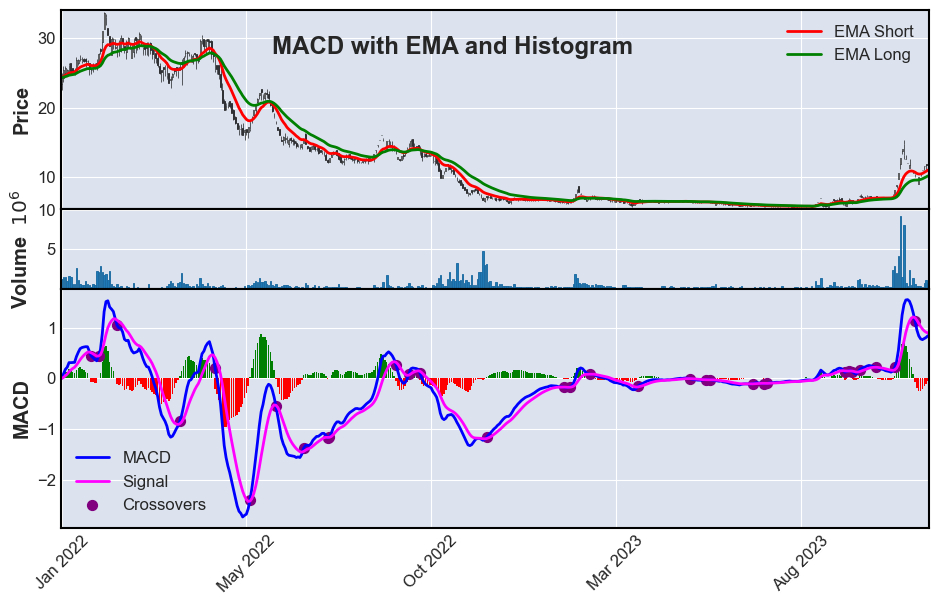

[runtime logging] log_function_use: autogen logger is None


Backtesting_Specialist_Executor (to Backtesting_Specialist):

Backtesting_Specialist_Executor (to Backtesting_Specialist):

***** Response from calling tool (call_SVBlPRFTREog7qMSSZuFRTCC) *****
Displayed image from test.png
**********************************************************************

--------------------------------------------------------------------------------
Backtesting_Specialist (to Backtesting_Specialist_Executor):

Optimize the MACD parameters (short_ema, long_ema, and signal_ema) based on this image <img test.png>, and based on Backtest results. TERMINATE.

--------------------------------------------------------------------------------
User_Proxy (to Trade_Strategy_Optimizer):

Optimize the MACD parameters (short_ema, long_ema, and signal_ema) based on this image <image>, and based on Backtest results. .

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Trade_Strategy_Optimizer (to User_Proxy):

Based 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[runtime logging] log_function_use: autogen logger is None


Backtesting_Specialist_Executor (to Backtesting_Specialist):

Backtesting_Specialist_Executor (to Backtesting_Specialist):

***** Response from calling tool (call_a8o3T2IlW325Me3HZ6jMXy2w) *****
Back Test Finished. Results: 
{
  "Starting Portfolio Value": 10000.0,
  "Final Portfolio Value": 10007.489999999996,
  "Sharpe Ratio": {
    "sharperatio": -18.8785921666712
  },
  "Drawdown": {
    "len": 19,
    "drawdown": 0.004996008189456626,
    "moneydown": 0.5,
    "max": {
      "len": 208,
      "drawdown": 0.09769355222553931,
      "moneydown": 9.769999999998618
    }
  },
  "Returns": {
    "rtot": 0.0007487196394842831,
    "ravg": 1.334616113162715e-06,
    "rnorm": 0.00033637982352576075,
    "rnorm100": 0.033637982352576076
  },
  "Trade Analysis": {
    "total": {
      "total": 18,
      "open": 0,
      "closed": 18
    },
    "streak": {
      "won": {
        "current": 1,
        "longest": 3
      },
      "lost": {
        "current": 0,
        "longest": 6
      }
   

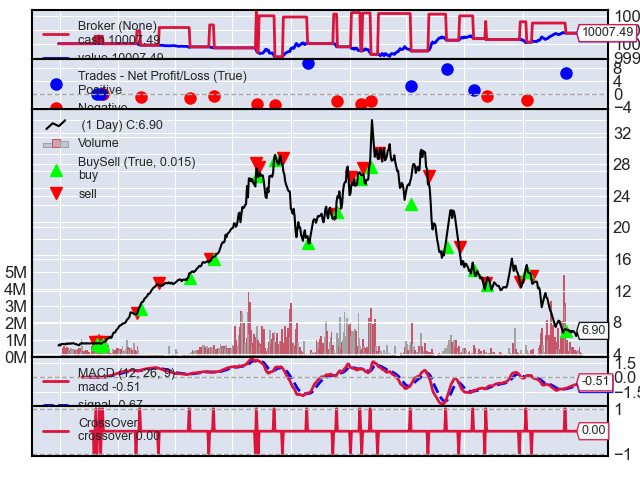

[runtime logging] log_function_use: autogen logger is None


Backtesting_Specialist_Executor (to Backtesting_Specialist):

Backtesting_Specialist_Executor (to Backtesting_Specialist):

***** Response from calling tool (call_a8o3T2IlW325Me3HZ6jMXy2w) *****
Displayed image from test.png
**********************************************************************

--------------------------------------------------------------------------------
Backtesting_Specialist (to Backtesting_Specialist_Executor):

Optimize the MACD parameters (short_ema, long_ema, and signal_ema) based on this image <img test.png>, and based on Backtest results. TERMINATE.

--------------------------------------------------------------------------------
User_Proxy (to Trade_Strategy_Optimizer):

Optimize the MACD parameters (short_ema, long_ema, and signal_ema) based on this image <image>, and based on Backtest results. .

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Trade_Strategy_Optimizer (to User_Proxy):

Based 

In [127]:
# Configure the User Proxy agent
user_proxy = UserProxyAgent(
    name="User_Proxy",
    is_termination_msg=lambda x: x.get("content", "") and x.get("content", "").endswith("TERMINATE"),
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    code_execution_config={
        "last_n_messages": 1,
        "work_dir": "coding",
        "use_docker": False,
    },
)
# Register nested chat scenarios for the proxy agent
user_proxy.register_nested_chats(
    [
        {
            "sender": backtesting_specialist_executor,
            "recipient": backtesting_specialist,
            "message": reflection_message_analyst,
            "max_turns": 10,
            "summary_method": "last_msg",
        }
    ],
    trigger=trade_strategy_optimizer,
)
# Define the task for the Trade Strategy Optimizer agent
task = dedent(f"""
    Based on {company}'s stock data from {start_date} to {end_date} in the file at {file_path}, determine the possible optimal parameters for a MACD Strategy over this period.
    First, ask the backtesting_specialist to plot a candlestick chart of the stock price data with MACD indicators to visually carefully inspect the price movements and make an initial assessment.
    Then, ask the backtesting_specialist to backtest the MACD (short_ema,long_ema and signal_ema) strategy parameters using the backtesting tool, and report results back for further optimization.
""")

# Start logging with logger_type and the filename to log to
# logging_session_id = autogen.runtime_logging.start(logger_type="file", config={"filename": "runtime.log"})
# print("Logging session ID: " + str(logging_session_id))

# Initialize the chat with the trade_strategy_optimizer agent and execute the task
with Cache.disk() as cache:
    user_proxy.initiate_chat(
        recipient=trade_strategy_optimizer, message=task, max_turns=3, summary_method="last_msg"
    )
# autogen.runtime_logging.stop()

         This version of jupyter notebook focussed on different enhancements including improvements in MACD charts, parameter fine-tuning and prompts(system_message), code refactoring and annotations. Based on these enhancements, there is improvement observed in the interpretation of the chart and thus better suggestions of the parameter by the model GPT4-o. Further details can be found in the project document. Overall, We have used the mplfinance and Backtrader libraries and integrated Autogen AI agent with LLM multimodal vision model GPT-4o for optimization of MACD trading strategies. As per the analysis based on the experiments conducted so far, Autogen with LLM multi-model approach shows good potential for understanding MACD charts and parameters, and possibly other technical indicators as well. The GPT-4o model was observed right about bullish/bearish trends including MACD line crossings while intial parameters were adjusted iteratively. There is always a scope of further fine-tuning and prompt engineering which can bring better results and accurate interpretation making false signals reduced further.